In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import os
import plytrons.bcm_sphere as bcm
from plytrons.bcm_sphere import EField, BCMObject


In [37]:
# ------------------------------------------------------------------------
# Define constants
# -------------------------------------------------------------------------
eps0 = 0.055263493756          # Vacuum permittivity (e/V-nm)
c0 = 299792458                 # Speed of light (m/s)
hbar = 1.0546e-34              # planck constant (J*s)
eV = 1.6022e-19                # electron-volts convertion 
Z0 = 377 * 1.6022e-19          # Free space impedance (e/V-s)

# Define geometrical parameters
D = 5                      # Diameter of spheres (nm)
dx = 2                      # Spacing between spheres (nm)
d_c = D + dx                # Distance between centers (nm) 
lmax = 10                   # Maximum spherical harmonic index

# Define External field
efield = EField(
    E0=1,                             # E-field intensity (V/nm)
    # k_hat=bcm.v_normalize([0, 0, 1]),     # Planewave direction
    # e_hat=bcm.v_normalize([1, 0, 0])      # E-field vector
    k_hat=bcm.v_normalize([0, 0, 1]),     # Planewave direction
    e_hat=bcm.v_normalize([0, 1, 0])      # E-field vector
    # k_hat=bcm.v_normalize([1, 0, 0]),     # Planewave direction
    # e_hat=bcm.v_normalize([0, 0, 1])      # E-field vector
)

# Define simulation setup
eps_h = 1                           # Dielectric constant of host
w = np.linspace(3.2, 4.0, 100) * eV / hbar  # frequencies
lambda_vals = 2 * pi * c0 / w * 1E6  # wavelength spectrum (um)

# Define Drude model (silver)
wp = 9.07 * eV / hbar  # rad/s
gw = 0.060 * eV / hbar  # rad/s
eps_b = 4.18

def eps_drude(x):
    return eps_b - wp**2 / ((2 * pi * c0 / x * 1E6) * ((2 * pi * c0 / x * 1E6) + 1j * gw))

# Define sphere objects
BCM_objects = [
    BCMObject(
        label='Sphere1',
        diameter=D,
        lmax=lmax,
        eps=eps_drude,
        position=np.array([0, 0, 0])
    #     position=np.array([0, -np.sqrt(3)/2 * d_c, 0])
    # ),
    # BCMObject(
    #     label='Sphere2',
    #     diameter=D,
    #     lmax=lmax,
    #     eps=eps_drude,
    #     position=np.array([d_c/2, 0, 0])
    # ),
    # BCMObject(
    #     label='Sphere3',
    #     diameter=D,
    #     lmax=lmax,
    #     eps=eps_drude,
    #     position=np.array([-d_c/2, 0, 0])
    )
]

In [38]:
# Number of spheres
Np = len(BCM_objects)

# Compute interaction matrices and vector
Gi = [None] * Np
G0 = [[None for _ in range(Np)] for _ in range(Np)]
Sv = [None] * Np

for in_idx in range(Np):
    # Compute internal matrix
    Gi[in_idx] = bcm.Ginternal(BCM_objects[in_idx])
    
    # Compute external interaction matrix
    for jn_idx in range(Np):
        G0[in_idx][jn_idx] = bcm.Gexternal(BCM_objects[in_idx], BCM_objects[jn_idx])
    
    # Compute external field coefficients
    Sv[in_idx] = bcm.Efield_coupling(BCM_objects[in_idx], efield)
    
#-----------------------------------------------------------------------------------------------------
# Solve system
#-----------------------------------------------------------------------------------------------------
Sw = [None] * Np

dx_max = lmax * (lmax + 1) + (lmax + 1) - 1

obj_coef = []
for coef in BCM_objects:
    obj_coef.append(np.zeros((dx_max, len(w)), dtype=complex))

for il in range(len(w)):
    c, Si = bcm.solve_BCM(w[il], eps_h, BCM_objects, efield, Gi, G0, Sv)
    for in_idx in range(Np):
        obj_coef[in_idx][:, il] = c[in_idx]
        if il == 0:
            Sw[in_idx] = np.zeros((len(Si[in_idx]), len(w)), dtype=complex)
        Sw[in_idx][:, il] = Si[in_idx]

lam_um = 2*np.pi*3E14/w
for idx_obj in range(Np):
    BCM_objects[idx_obj].set_coefficients(lam_um, obj_coef[idx_obj])

In [39]:
eps0 = 0.055263493756
D = 5
R = D/2
eps0*np.sqrt(2*np.pi/3)*np.sqrt(1 / R**3)

0.020232876532915375

In [40]:
Sv[0]

array([ 2.38244732e-18-2.02328766e-02j, -1.41812340e-20+0.00000000e+00j,
       -2.38244732e-18-2.02328766e-02j, -4.17150105e-18+5.77592453e-18j,
        6.01658806e-20+4.41216458e-19j,  9.62654089e-19+0.00000000e+00j,
       -6.01658806e-20+4.41216458e-19j, -4.17150105e-18-5.77592453e-18j,
        1.04145500e-17-5.50202641e-18j,  2.45626179e-19+4.91252358e-20j,
        9.82504715e-20-3.24046712e-10j,  2.69229319e-19+0.00000000e+00j,
       -9.82504715e-20-3.24046712e-10j,  2.45626179e-19-4.91252358e-20j,
       -1.04145500e-17-5.50202641e-18j,  9.89850137e-18+5.89939336e-18j,
        5.03433809e-19+2.83624681e-20j, -1.92155721e-18-6.78926580e-19j,
       -2.83624681e-19-1.03523009e-18j,  7.01971085e-19+0.00000000e+00j,
        2.83624681e-19-1.03523009e-18j, -1.92155721e-18+6.78926580e-19j,
       -5.03433809e-19+2.83624681e-20j,  9.89850137e-18-5.89939336e-18j,
       -8.75201612e-18+2.08018934e-17j, -1.07021936e-19+1.26840813e-18j,
        4.28087745e-19-5.32731416e-18j,  1.58551017

/mnt/c/Users/frami/OneDrive - Universidad Adolfo Ibanez/ComputerCodes/Python/plasmon-hc-clusters/plytrons/bcm_sphere.py:252: RuntimeWarning: invalid value encountered in divide
  vector = np.array(vector) / np.array(vector)


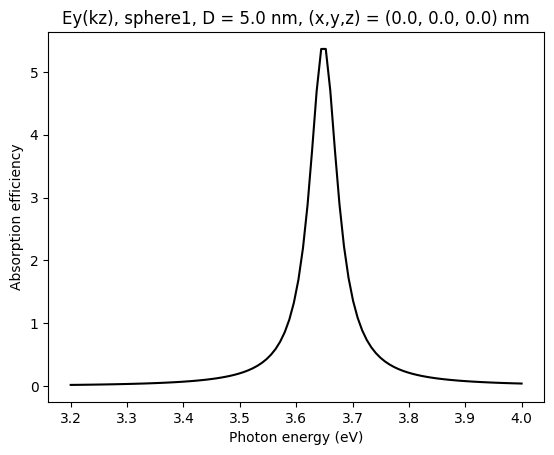

In [41]:
# Compute scattering and absorption
Psca, Pabs = bcm.EM_power(w, eps_h, Gi, G0, BCM_objects)

# Create output folder
folder_name = f'D{BCM_objects[0].diameter}nm_Ns{len(BCM_objects)}_dr{d_c:.1f}nm_k{bcm.get_axis(efield.k_hat)}E{bcm.get_axis(efield.e_hat)}'

if not os.path.isdir(folder_name):
    os.mkdir(folder_name)

# Save data and plots
current_dir = os.getcwd()
os.chdir(folder_name)

for in_idx, obj in enumerate(BCM_objects):
    # Create tag for particle data
    sphere_file_name = f'S{in_idx+1}_D{obj.diameter}nm_x{obj.position[0]:.1f}_y{obj.position[1]:.1f}_z{obj.position[2]:.1f}'
    
    # Plot and save figure of spectrum
    plt.figure()
    Ri = obj.diameter / 2
    plt.plot(w * hbar / eV, Pabs[in_idx] / (efield.E0**2 / (2 * Z0)) / (pi * Ri**2), 'k')
    
    plt.title(f'E{bcm.get_axis(efield.e_hat)}(k{bcm.get_axis(efield.k_hat)}), sphere{in_idx+1}, ' +
                f'D = {obj.diameter:.1f} nm, (x,y,z) = ({obj.position[0]:.1f}, {obj.position[1]:.1f}, {obj.position[2]:.1f}) nm')
    plt.xlabel('Photon energy (eV)')
    plt.ylabel('Absorption efficiency')
    
    plt.savefig(f'{sphere_file_name}.jpg')
    plt.savefig(f'{sphere_file_name}.png')
    
    # Save spectra as tabulated data as *.csv file
    with open(f'spectra_{sphere_file_name}.csv', 'w') as f:
        f.write('# hv (eV), Qabs\n')
        for i in range(len(w)):
            f.write(f'{w[i] * hbar / eV:.5f}, {Pabs[in_idx][i] / (efield.E0**2 / (2 * Z0)) / (pi * Ri**2):.5f}\n')
    
    # Save coefficients in a *.csv file
    with open(f'coefficients_{sphere_file_name}.csv', 'w') as f:
        # Write header
        header = '"lambda (um)", '
        idx = 0
        for l in range(1, obj.lmax + 1):
            for m in range(-l, l + 1):
                header += f'({l}_ {m})'
                if not (l == obj.lmax and m == l):
                    header += ', '
        f.write(header + '\n')
        
        # Write data
        for i in range(len(lambda_vals)):
            line = f'{lambda_vals[i]:.6f}, '
            idx = 0
            for l in range(1, obj.lmax + 1):
                for m in range(-l, l + 1):
                    if idx < obj.BCM_coef.shape[0]:  # Ensure we don't go out of bounds
                        line += f'{obj.BCM_coef[idx, i].real:.6e}{obj.BCM_coef[idx, i].imag:+.6e}j'
                        if not (l == obj.lmax and m == l):
                            line += ', '
                        idx += 1
            f.write(line + '\n')

os.chdir(current_dir)